In [178]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.optimize import curve_fit
from cycler import cycler
# plt.style.use('stylesheets/sobrio.mplstyle')

In [179]:
plt.rcdefaults()

# axes
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['axes.prop_cycle'] = cycler('color', ['teal', 'firebrick', 'olive', 'navy', 'darkgoldenrod', 'darkorchid', 'slategray', 'mediumvioletred', 'saddlebrown', 'black'])
# figure:
rcParams['figure.autolayout'] = True
rcParams['figure.dpi'] = 100

# fontsizes
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['legend.title_fontsize'] = 12
rcParams['axes.labelsize'] = 16
# rcParams['axes.title.size'] = 16

rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'

rcParams['figure.figsize'] = [7.4, 4.8]

# legend
# rcParams['legend.framealpha'] = 1
rcParams['legend.fancybox'] = False
rcParams['legend.edgecolor'] = 'gray'


# save
rcParams['savefig.bbox'] = 'tight'

In [180]:
def extraccion(datos):
    t = datos[2:].T[0] # segundos
    lista_pos=[]
    lista_bien  = []
    for i in range(1, len(datos[0]), 2):
        xy = []
        for j in datos:
            if np.isnan(j[i]) == False: 
                xy.append([j[i], j[i+1]])
        xy = np.array(xy)
        lista_pos.append(xy)
    for part in lista_pos:
        np.stack(part)
        lista_bien.append(pixel_a_micron(part.T)*1e-6) # metros
    return t, lista_bien

def MSD(x, y, err_d):
    suma=0
    suma_err = 0
    for n in range(len(x)):
        suma+=(x[n]-x[0])**2+(y[n]-y[0])**2
        suma_err += x[n]-x[0] + y[n]-y[0]
    err_MSD = 2*err_d*np.sqrt(suma + suma_err**2)/len(x)
    MSD = suma/len(x)
    return MSD, err_MSD

def MSD_data(lista_bien, err_d):
    lista_MSD = []
    err_lista_MSD = []
    for n, part in enumerate(lista_bien):
        x = part[0]
        y = part[1]
        part_MSD = []
        err_part_MSD = []
        for i in range(len(x)):    
            msd, err = MSD(x[:i+1], y[:i+1], err_d)
            part_MSD.append(msd)
            err_part_MSD.append(err)
        lista_MSD.append(part_MSD)
        err_lista_MSD.append(err_part_MSD)
    return lista_MSD, err_lista_MSD

def promedio(lista_MSD, err_listaMSD):
    MSD_promedio = []
    err_promedio = []
    for n in range(len(lista_MSD[0])): 
        val = 0
        sigma = 0
        for disp in lista_MSD:
            val += disp[n]
        for e in err_listaMSD:
            sigma += e[n]**2
        MSD_promedio.append(val/len(lista_MSD))
        err_promedio.append(np.sqrt(sigma)/len(err_listaMSD))
    return MSD_promedio, err_promedio

def lineal(x, a):
    return a*x

def viscosidad(m, R, T, err_m, err_R, err_T):
    neff = 2*1.38*1e-23*T/(3*np.pi*R*m)
    err_neff = (2*1.38*1e-23/(3*np.pi))*np.sqrt((err_T/(R*m))**2 + (err_R*(T/((R**2)*m)))**2 + (err_m*T/(R*(m**2)))**2) # propagación de errores
    return neff, err_neff


def fuerza_V(R, neff, v, err_R, err_n, err_v):
    F = 6*np.pi*neff*R*v
    err_F = 6*np.pi*np.sqrt((R*v*err_n)**2 + (neff*v*err_R)**2 + (neff*R*err_v)**2)
    return F, err_F

def pixel_a_micron(pix): # toma píxeles devuelve micrones
    escala = 10/106.04
    micro = pix*escala
    return micro

def celsius_a_k(g):
    return g+273.15

In [181]:
datos_1 = np.genfromtxt('Mediciones/browniano solo agua pixel.txt', delimiter=',') # CLASE 3, dan mal
datos_2 = np.genfromtxt('Mediciones/browniano 1 en 2 pixel.txt', delimiter=',') # CLASE 3, dan mal
datos_3 = np.genfromtxt('Mediciones/browniano 1 en 2 clase 4 pixel.txt', delimiter=',') # CLASE 4, dan bien, usamos estos para coefs
datos_4 = np.genfromtxt('Mediciones/browniano agua mq clase4_1 pixel.txt', delimiter=',') # CLASE 4, dan bien, usamos estos para coefs
datos_5 = np.genfromtxt('Mediciones/muestra agua mq browniano.txt', delimiter=',') # CLASE 1, sólo gráficos iniciales
datos_6 = np.genfromtxt('Mediciones/browniano 1 en 1 pixel.txt', delimiter=',') # CLASE 1, sólo gráficos iniciales

muestras = ['Agua mQ clase 3', 'Glicerina 1 en 2 clase 3', 'Glicerina 1 en 2 clase 4', 'Agua mQ clase 4']

t_1, data_1 = extraccion(datos_1)
t_2, data_2 = extraccion(datos_2)
t_3, data_3 = extraccion(datos_3)
t_4, data_4 = extraccion(datos_4)
t_5, data_5 = extraccion(datos_5)
t_6, data_6 = extraccion(datos_6)

tiempos = [t_1, t_2, t_3, t_4, t_5, t_6]
lista_data = [data_1, data_2, data_3, data_4, data_5, data_6]

radio_px = 25

err_tiempos = [np.ones(len(t))/9.19 for t in tiempos]
err_d = pixel_a_micron(12.5/4)*1e-6 # metros

In [182]:
lista_MSD = []
err_lista_MSD = []

for i in range(len(tiempos)):
    MSD_val, err_MSD = MSD_data(lista_data[i], err_d)
    lista_MSD.append(MSD_val)
    err_lista_MSD.append(err_MSD)

lista_MSD_prom = []
err_lista_prom_MSD = []

for i in range(len(tiempos)):
    MSD_prom, err_prom = promedio(lista_MSD[i], err_lista_MSD[i])
    lista_MSD_prom.append(MSD_prom)
    err_lista_prom_MSD.append(err_prom)

c:\Users\pauli\miniconda3\envs\Labo5_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\pauli\miniconda3\envs\Labo5_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


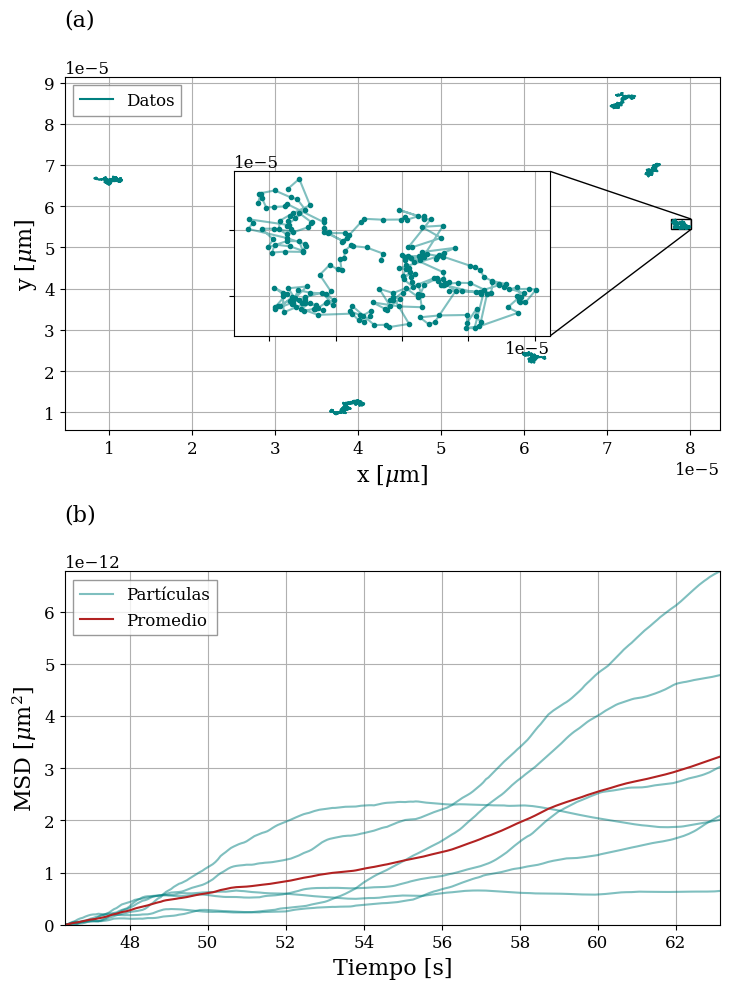

In [183]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.4, 10))
for n, part in enumerate(lista_data[4]):
    x = part[0]
    y = part[1]
    ax1.plot(x, y, color='teal')
ax1.plot(x, y, label='Datos')
ax1.set_xlabel(r'x [$\mu$m]')
ax1.set_ylabel(r'y [$\mu$m]')
ax1.legend()
ax1.set_title('(a)\n', loc='left', fontsize=16)

x = lista_data[4][0][0]
y = lista_data[4][0][1]


x1 = x[0]
x2 = x[-1]

y1 = y[0]
y2 = y[-1]

axins = zoomed_inset_axes(ax1, 16, loc=10)
axins.plot(x, y, color='teal', alpha=0.5)
axins.plot(x, y, '.', color='teal')
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax1, axins, loc1=1, loc2=4, fc="none", ec="0")

for n, disp in enumerate(lista_MSD[4]):
    t5 = t_5[:len(disp)] # esto es porque hay un frame menos de la prtícula 8, asi que para plotear tengo que acortar el tiempo a la longitud de cada set de datos 
    ax2.plot(t5, disp, color='teal', alpha=0.5)
ax2.plot(t5[:1], disp[:1], color='teal', label='Partículas', alpha=0.5)
ax2.plot(t_5[:len(lista_MSD_prom[4])], lista_MSD_prom[4], label='Promedio', color='firebrick')
ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel(r'MSD [$\mu$m$^2]$')
ax2.set_xmargin(0)
ax2.set_ymargin(0)
ax2.set_title('(b)\n', loc='left', fontsize=16)
ax2.legend()

# plt.savefig('Gráficos/ej browniano agua mQ.pdf', format='pdf', dpi=150)

In [184]:
# Ajuste:
m_lista = []
err_m_lista = []
r_cuadrado_lista = []

for i, t in enumerate(tiempos):
    popt_lin, pcov_lin = curve_fit(lineal, t[:len(lista_MSD_prom[i])], lista_MSD_prom[i], p0=[50])
    m = popt_lin
    perr_lin = np.sqrt(np.diag(pcov_lin))
    err_m = perr_lin
    m_lista.append(m)
    err_m_lista.append(err_m)

    # R^2:
    res_lin = lista_MSD_prom[i] - lineal(t[:len(lista_MSD_prom[i])], *popt_lin)
    ss_res_lin = np.sum(res_lin**2)
    ss_tot_lin = np.sum((lista_MSD_prom[i] - np.mean(lista_MSD_prom[i]))**2)
    r_cuadrado_lin = 1 - (ss_res_lin / ss_tot_lin)
    r_cuadrado_lista.append(r_cuadrado_lin)


    print(f'Ajuste lineal data {i+1} m*x:\nm = {m} +- {err_m}\nR^2 = {r_cuadrado_lin}\n')

Ajuste lineal data 1 m*x:
m = [1.43699533e-13] +- [8.01085909e-16]
R^2 = 0.8917626734220282

Ajuste lineal data 2 m*x:
m = [3.30186912e-13] +- [7.5620354e-16]
R^2 = 0.9878087463956272

Ajuste lineal data 3 m*x:
m = [1.41967114e-13] +- [2.44582835e-15]
R^2 = 0.9207602713385042

Ajuste lineal data 4 m*x:
m = [3.58090766e-13] +- [3.84450231e-15]
R^2 = 0.9647698327628839

Ajuste lineal data 5 m*x:
m = [2.71793855e-14] +- [9.23808363e-16]
R^2 = 0.2539941725960263

Ajuste lineal data 6 m*x:
m = [4.76829031e-14] +- [2.49546474e-16]
R^2 = 0.8948905005630651



In [185]:
radio = pixel_a_micron(radio_px)*1e-6 # el 1e-6 lo pasa a metros para tener el neff en unidades razonables

T_celsius = 25.7
T = celsius_a_k(T_celsius)

lista_D = []
err_lista_D = []
lista_neff = []
err_lista_neff = []
lista_fv = []
err_lista_fv = []

for i in range(len(tiempos)):
    D, err_D = (m_lista[i]/4, err_m_lista[i]/4) 
    neff, err_neff = viscosidad(m_lista[i], radio, T, err_m_lista[i], err_d, 0.1)
    fv, err_fv = fuerza_V(radio, neff, 8*1e-6, err_d, err_neff, 1*1e-6) # v y err_v en metros
    lista_D.append(D)
    err_lista_D.append(err_D)
    lista_neff.append(neff)
    err_lista_neff.append(err_neff)
    lista_fv.append(fv)
    err_lista_fv.append(err_fv)

    print(f'Muestra n° {i+1}\nDifusividad: {D} +- {err_D}\nCoeficiente de viscosidad: {neff} +- {err_neff}\nFuerza del láser: {fv} +- {err_fv}\n')

Muestra n° 1
Difusividad: [3.59248833e-14] +- [2.00271477e-16]
Coeficiente de viscosidad: [0.00258324] +- [0.00032323]
Fuerza del láser: [9.18389621e-13] +- [1.98903326e-13]

Muestra n° 2
Difusividad: [8.2546728e-14] +- [1.89050885e-16]
Coeficiente de viscosidad: [0.00112425] +- [0.00014055]
Fuerza del láser: [3.99689252e-13] +- [8.65402063e-14]

Muestra n° 3
Difusividad: [3.54917785e-14] +- [6.11457088e-16]
Coeficiente de viscosidad: [0.00261477] +- [0.00032994]
Fuerza del láser: [9.29596696e-13] +- [2.01900015e-13]

Muestra n° 4
Difusividad: [8.95226915e-14] +- [9.61125578e-16]
Coeficiente de viscosidad: [0.00103664] +- [0.00013006]
Fuerza del láser: [3.68543879e-13] +- [7.98902284e-14]

Muestra n° 5
Difusividad: [6.79484638e-15] +- [2.30952091e-16]
Coeficiente de viscosidad: [0.01365782] +- [0.00176922]
Fuerza del láser: [4.85559763e-12] +- [1.06414479e-12]

Muestra n° 6
Difusividad: [1.19207258e-14] +- [6.23866186e-17]
Coeficiente de viscosidad: [0.00778499] +- [0.00097398]
Fuerza 

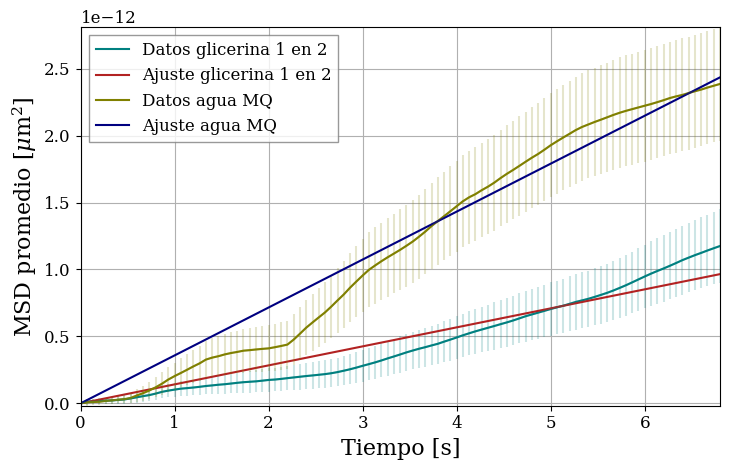

In [188]:
fig, ax = plt.subplots()

# agua MQ:
# x = np.linspace(t_1[0], t_1[:len(lista_MSD_prom[0])][-1], 1000)
# y_fit_lin = lineal(x, m_lista[0])

# ax.errorbar(t_1[:len(lista_MSD_prom[0])], lista_MSD_prom[0], err_lista_prom_MSD[0], alpha = 0.1, color='teal', label='Barras de error')
# ax.plot(t_1[:len(lista_MSD_prom[0])], lista_MSD_prom[0], label='Datos agua MQ clase 3')
# ax.plot(x, y_fit_lin, label='Ajuste agua MQ clase 3')

# # 1 en 2:
# x = np.linspace(t_2[0], t_2[:len(lista_MSD_prom[1])][-1], 1000)
# y_fit_lin = lineal(x, m_lista[1])

# ax.errorbar(t_2[:len(lista_MSD_prom[1])], lista_MSD_prom[1], err_lista_prom_MSD[1], alpha = 0.1, color='olive')
# ax.plot(t_2[:len(lista_MSD_prom[1])], lista_MSD_prom[1], label='Datos glicerina 1 en 2 clase 3')
# ax.plot(x, y_fit_lin, label='Ajuste glicerina 1 en 2 clase 3')

# # 1 en 2:
x = np.linspace(t_3[0], t_3[:len(lista_MSD_prom[2])][-1], 1000)
y_fit_lin = lineal(x, m_lista[2])

ax.errorbar(t_3[:len(lista_MSD_prom[2])], lista_MSD_prom[2], err_lista_prom_MSD[2], alpha = 0.2, color='teal')
ax.plot(t_3[:len(lista_MSD_prom[2])], lista_MSD_prom[2], label='Datos glicerina 1 en 2')
ax.plot(x, y_fit_lin, label='Ajuste glicerina 1 en 2')

x = np.linspace(t_4[0], t_4[:len(lista_MSD_prom[3])][-1], 1000)
y_fit_lin = lineal(x, m_lista[3])

ax.errorbar(t_4[:len(lista_MSD_prom[3])], lista_MSD_prom[3], err_lista_prom_MSD[3], alpha = 0.2, color='olive')
ax.plot(t_4[:len(lista_MSD_prom[3])], lista_MSD_prom[3], label='Datos agua MQ')
ax.plot(x, y_fit_lin, label='Ajuste agua MQ')

ax.set_xlabel('Tiempo [s]')
ax.set_ylabel(r'MSD promedio [$\mu$m$^2]$')
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.legend()

# plt.savefig('Gráficos/comparacion ajuste.pdf', format='pdf', dpi=150)

<Axes: >

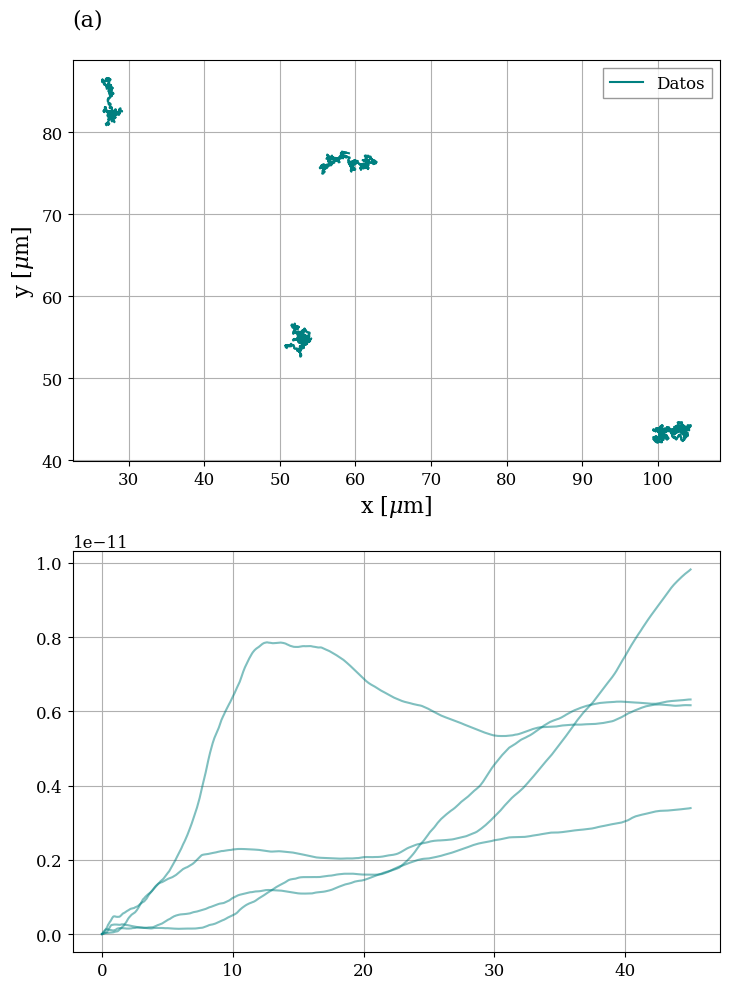

In [193]:
# leche

datos_le = np.genfromtxt('Mediciones/browniano solo agua pixel.txt', delimiter=',') # CLASE 3, dan mal
t_le, data_le = extraccion(datos_le)
MSD_le, err_MSD_le = MSD_data(data_le, err_d)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.4, 10))
for n, part in enumerate(data_le):
    x = part[0]*1e6
    y = part[1]*1e6
    ax1.plot(x, y, color='teal')
    ax2.plot(t_le, MSD_le[n], color='teal', alpha=0.5)
ax1.plot(x, y, label='Datos')
ax1.set_xlabel(r'x [$\mu$m]')
ax1.set_ylabel(r'y [$\mu$m]')
ax1.legend()
ax1.set_title('(a)\n', loc='left', fontsize=16)


ax2